In [21]:
import numpy as np
import pandas as pd

# -----------------------------
# CONFIGURABLE PARAMETERS
# -----------------------------
rng = np.random.default_rng(123)      # reproducibility
n_skus = 50                           # total SKUs
start = "2023-01-01"
end = "2025-06-28"
zero_inflation = 0.7                  # sparsity level
base_lambda = 5

# Group definitions
positive_group = list(range(0, 5))                   # positively correlated SKUs 0‑4
negative_groups = [                                  # groups with internal negative correlation
    list(range(5, 10)),                              # 5 SKUs each
    list(range(10, 15)),
    list(range(15, 20)),
]
# Remaining SKUs (20‑49) will be independent
# -----------------------------

# Build calendar & seasonality signals
dates = pd.date_range(start, end, freq="D")
n_days = len(dates)
day_of_year = dates.dayofyear
yearly = np.sin(2 * np.pi * day_of_year / 365.25)    # annual
weekly = np.where(dates.weekday < 5, 1.0, 1.3)       # weekend uplift
seasonality_signal = (yearly + 1) * weekly

frames = []

# ----- Positive‑correlated SKUs -----
shared_noise_pos = rng.normal(0, 0.3, n_days)
for sku in positive_group:
    mean = base_lambda + 3 * seasonality_signal + shared_noise_pos
    lam = np.exp(mean / 5)
    sales = rng.poisson(lam)
    sales[rng.random(n_days) < zero_inflation] = 0
    frames.append(pd.DataFrame({"date": dates, "sku_id": sku, "sales": sales}))

# ----- Negative‑correlated groups -----
for group in negative_groups:
    # Group‑level demand
    group_noise = rng.normal(0, 0.4, n_days)
    group_mean = base_lambda + 3 * seasonality_signal + group_noise
    group_lambda = np.exp(group_mean / 5)
    group_sales = rng.poisson(group_lambda)

    k = len(group)
    # For each day, draw allocation probabilities from a Dirichlet
    alpha = np.ones(k) * 0.8                              # concentration < 1 → spikier allocations
    probs = rng.dirichlet(alpha, n_days)                  # shape (n_days, k)

    # Allocate group sales to SKUs (negative corr because of compositional constraint)
    for j, sku in enumerate(group):
        sales = rng.binomial(group_sales, probs[:, j])    # approximate multinomial via binomial splits
        sales[rng.random(n_days) < zero_inflation] = 0
        frames.append(pd.DataFrame({"date": dates, "sku_id": sku, "sales": sales}))

# ----- Independent SKUs -----
independent_skus = [s for s in range(n_skus) if s not in positive_group and all(s not in g for g in negative_groups)]
for sku in independent_skus:
    mean = base_lambda + rng.normal(0, 0.5, n_days) + 2 * seasonality_signal
    lam = np.exp(mean / 5)
    sales = rng.poisson(lam)
    sales[rng.random(n_days) < zero_inflation] = 0
    frames.append(pd.DataFrame({"date": dates, "sku_id": sku, "sales": sales}))

# Assemble final DataFrame
df = pd.concat(frames, ignore_index=True).sort_values(["sku_id", "date"])

df = df.set_index(["sku_id", "date"])

In [35]:
import numpy as np
import pandas as pd

# ---------------------------- PARAMETERS -----------------------------
rng = np.random.default_rng(321)
n_skus = 50
start, end = "2024-01-01", "2025-06-28"
zero_inflation = 0.7
base_lambda = 5

positive_group = list(range(0, 5))
negative_groups = [list(range(5, 10)),
                   list(range(10, 15)),
                   list(range(15, 20))]
promo_prob, promo_effect = 0.05, 1.5
macro_trend_amp = 5
# ---------------------------------------------------------------------

# Calendar
dates = pd.date_range(start, end, freq="D")
n_days = len(dates)
day_of_year = dates.dayofyear.values
yearly = np.sin(2 * np.pi * day_of_year / 365.25)
weekly = np.where(dates.weekday < 5, 1.0, 1.3)
seasonality_signal = (yearly + 1) * weekly

# Exogenous: macro index
macro_index = 100 + macro_trend_amp * np.sin(2 * np.pi * day_of_year / 180) + rng.normal(0, 2, n_days)
macro_index_z = (macro_index - macro_index.mean()) / macro_index.std()

frames = []

def make_rows(sku, sales, promo_flags, group_id):
    return pd.DataFrame({
        "date": dates,
        "sku_id": sku,
        "sales": sales,
        "promo": promo_flags.astype(int),
        "macro_index": macro_index,
        "group_id": group_id
    })

# Positive-correlated SKUs
shared_noise_pos = rng.normal(0, 0.3, n_days)
for sku in positive_group:
    gamma = rng.normal(0.7, 0.2)
    promo_flags = rng.random(n_days) < promo_prob
    mean = (base_lambda + 3 * seasonality_signal + shared_noise_pos +
            gamma * macro_index_z + promo_effect * promo_flags)
    lam = np.exp(mean / 5)
    sales = rng.poisson(lam)
    sales[rng.random(n_days) < zero_inflation] = 0
    frames.append(make_rows(sku, sales, promo_flags, group_id=0))

# Negative-correlation groups
for g_idx, group in enumerate(negative_groups, start=1):
    k = len(group)
    gamma_group = rng.normal(0.5, 0.3)
    group_noise = rng.normal(0, 0.4, n_days)
    group_mean = (base_lambda + 3 * seasonality_signal +
                  group_noise + gamma_group * macro_index_z)
    group_lambda = np.exp(group_mean / 5)
    group_sales_total = rng.poisson(group_lambda)

    alpha = np.ones(k) * 0.8
    base_probs = rng.dirichlet(alpha, n_days)

    promo_mat = rng.random((n_days, k)) < promo_prob
    adj_probs = base_probs * (1 + 0.3 * promo_mat)
    adj_probs = adj_probs / adj_probs.sum(axis=1, keepdims=True)

    sales_mat = np.vstack([rng.multinomial(n=int(group_sales_total[d]), pvals=adj_probs[d])
                           for d in range(n_days)])

    zero_mask = rng.random((n_days, k)) < zero_inflation
    sales_mat[zero_mask] = 0
    for j, sku in enumerate(group):
        frames.append(make_rows(sku, sales_mat[:, j], promo_mat[:, j], group_id=g_idx))

# Independent SKUs
independent_skus = [s for s in range(n_skus)
                    if s not in positive_group and all(s not in g for g in negative_groups)]
for sku in independent_skus:
    gamma = rng.normal(0.0, 0.5)
    promo_flags = rng.random(n_days) < promo_prob
    mean = (base_lambda + 2 * seasonality_signal +
            rng.normal(0, 0.5, n_days) +
            gamma * macro_index_z +
            promo_effect * promo_flags)
    lam = np.exp(mean / 5)
    sales = rng.poisson(lam)
    sales[rng.random(n_days) < zero_inflation] = 0
    frames.append(make_rows(sku, sales, promo_flags, group_id=-1))

df = pd.concat(frames, ignore_index=True).sort_values(["sku_id", "date"])

df = df.set_index(["group_id", "sku_id", "date"])
df

sales  promo  macro_index
group_id sku_id date                                 
 0       0      2024-01-01      0      0    98.836715
                2024-01-02     10      1   101.192471
                2024-01-03      0      0    97.605945
                2024-01-04      0      0    97.717277
                2024-01-05      3      0   100.016002
...                           ...    ...          ...
-1       49     2025-06-24      0      0    95.714481
                2025-06-25     13      0   102.176436
                2025-06-26      0      0   103.999728
                2025-06-27      4      0   102.310656
                2025-06-28      5      0    98.117495

[27250 rows x 3 columns]

<Axes: xlabel='date'>

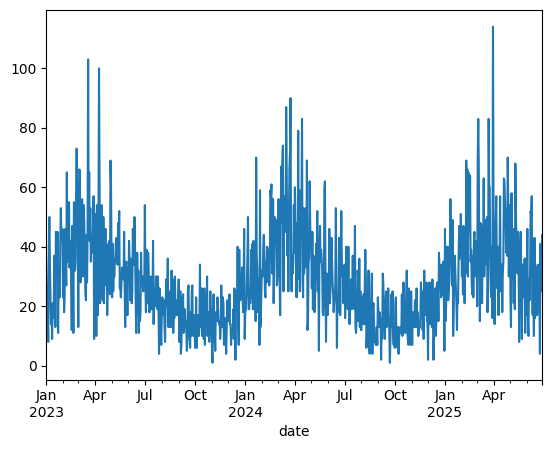

In [32]:
df["sales"].groupby(level=-1).sum().plot.line()

<Axes: title={'center': 'SKU 9 Sales Over Time'}, xlabel='date'>

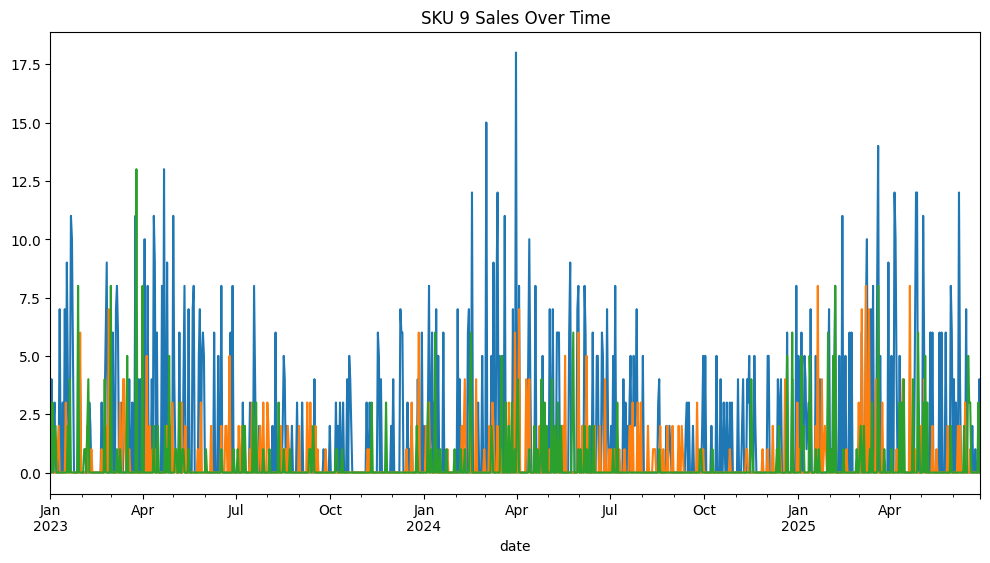

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df["sales"].loc[30].plot.line(title="SKU 9 Sales Over Time", ax=ax)
df["sales"].loc[7].plot.line(title="SKU 9 Sales Over Time", ax=ax)
df["sales"].loc[8].plot.line(title="SKU 9 Sales Over Time", ax=ax)

<Axes: title={'center': 'SKU 9 Sales Over Time'}, xlabel='date'>

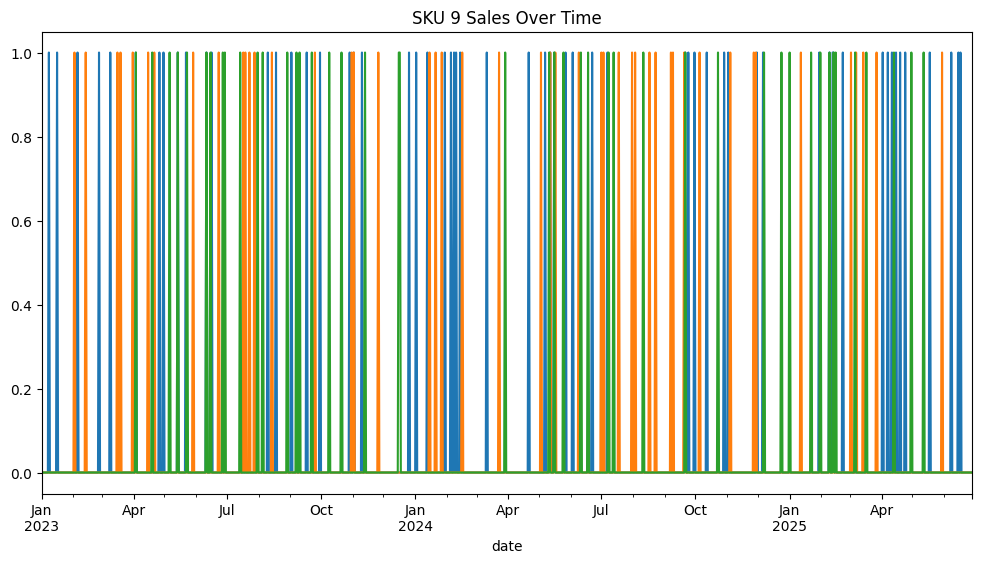

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df["promo"].loc[6].plot.line(title="SKU 9 Sales Over Time", ax=ax)
df["promo"].loc[7].plot.line(title="SKU 9 Sales Over Time", ax=ax)
df["promo"].loc[8].plot.line(title="SKU 9 Sales Over Time", ax=ax)